In [62]:
# 載入需要的套件
import os
import numpy as np 
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble, tree, linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# 設定 data_path
dir_data = './data/'
Train = os.path.join(dir_data, 'train.csv')
Test = os.path.join(dir_data, 'test.csv')

# 讀取檔案
Train_data = pd.read_csv(Train)
Test_data = pd.read_csv(Test)

In [3]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))

In [4]:
na_check(Train_data)

,Missing Ratio
parking_area,94.828333
parking_price,76.775000
txn_floor,26.503333
village_income_median,1.903333


In [5]:
na_check(Test_data)

,Missing Ratio
parking_area,95.00
parking_price,77.10
txn_floor,26.39
village_income_median,1.84


In [6]:
#check for dupes for Id
idsUnique = len(set(Train_data.building_id))
idsTotal = Train_data.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)
#drop id col
Train_data.drop(['building_id'],axis =1,inplace=True)

0


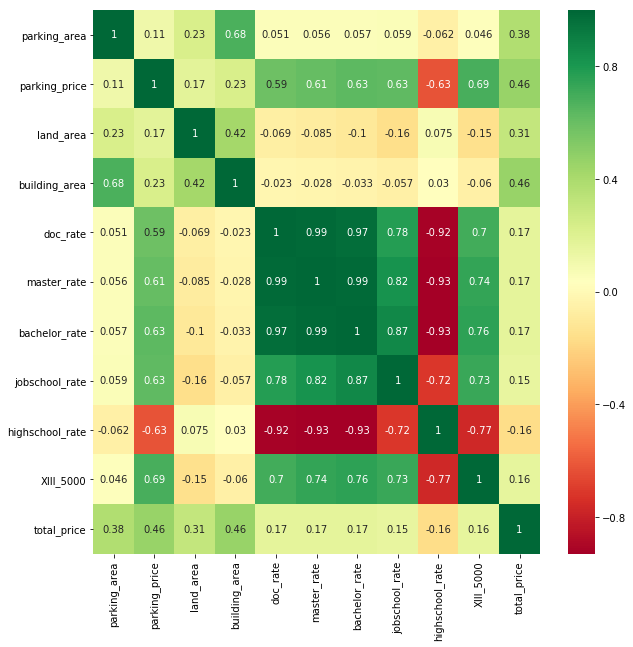

In [7]:
corrmat = Train_data.corr()
top_corr_features = corrmat.index[abs(corrmat["total_price"])>0.15]
plt.figure(figsize=(10,10))
g = sns.heatmap(Train_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

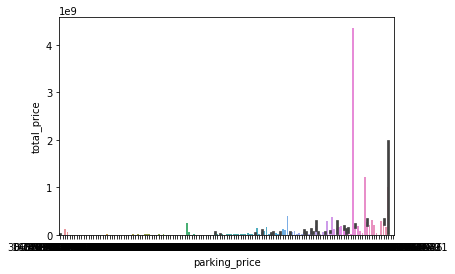

In [8]:
sns.barplot(Train_data.parking_price,Train_data.total_price)

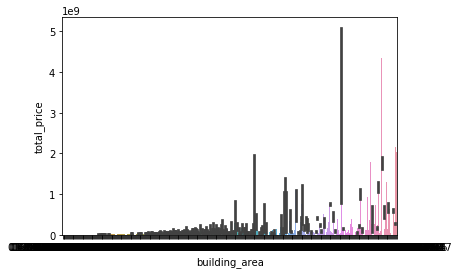

In [9]:
sns.barplot(Train_data.building_area,Train_data.total_price)

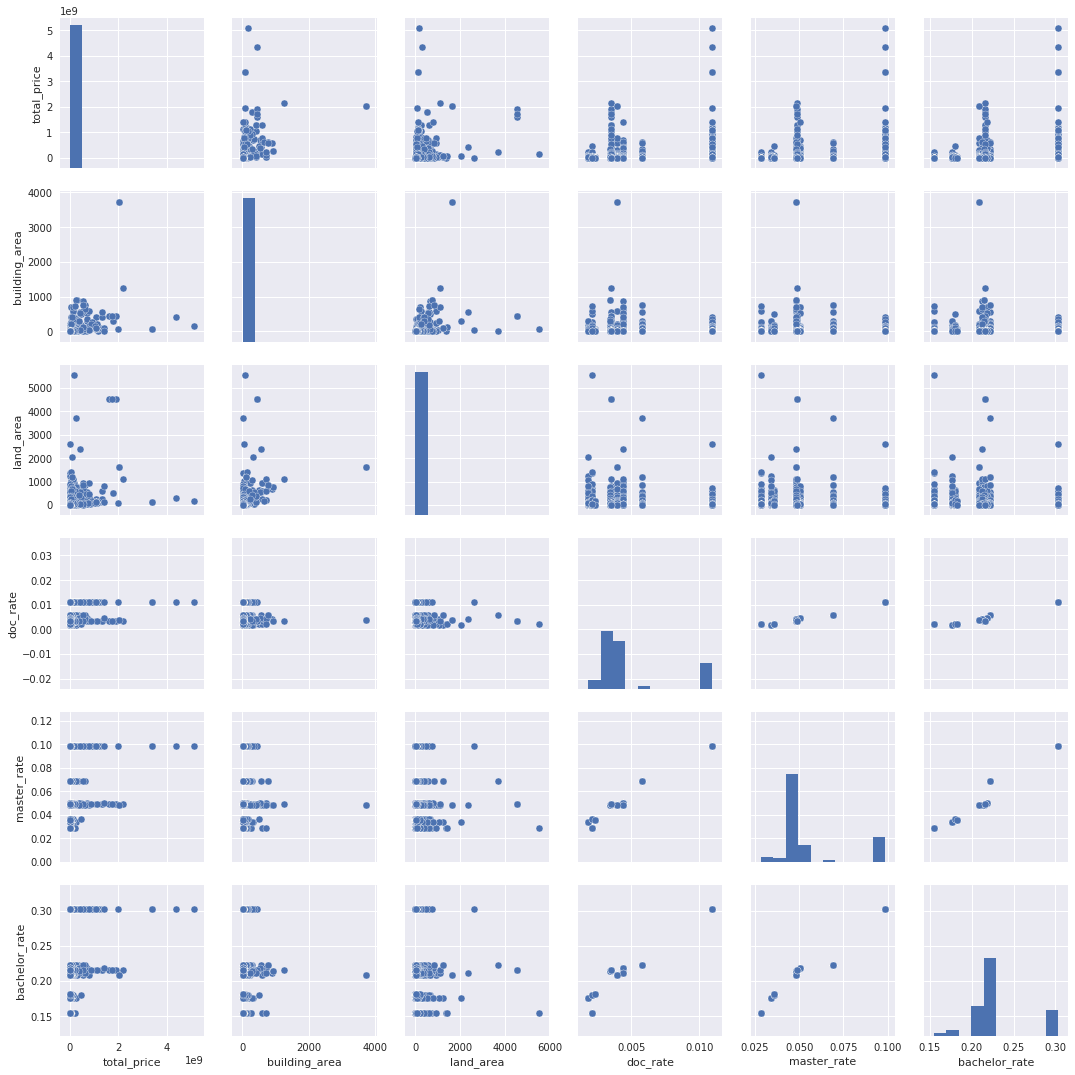

In [10]:
sns.set()
cols = ['total_price', 'building_area', 'land_area',
        'doc_rate', 'master_rate', "bachelor_rate"]
       #,'parking_area', 'parking_price']
sns.pairplot(Train_data[cols], size = 2.5)

plt.show();


 mu = 12937270.81 and sigma = 55224170.14



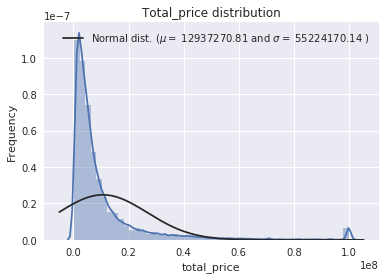

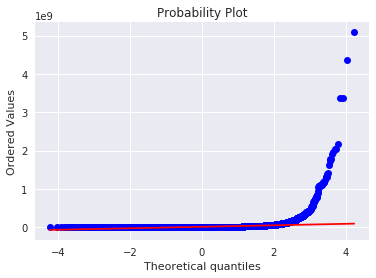

In [20]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(Train_data['total_price'].clip(1.e+05, 1.e+08) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Train_data['total_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Total_price distribution')

# 檢視對正態分佈的相似性，x軸為正態分佈的分位數，y軸為樣本分位數
# 如果兩者構成的點分佈在一條直線上，表示樣本數據與正態分佈存在線性相關性，及符合正態分佈
fig = plt.figure()
res = stats.probplot(Train_data['total_price'], plot=plt)
plt.show()

In [21]:
train_Y = np.log1p(Train_data['total_price'])

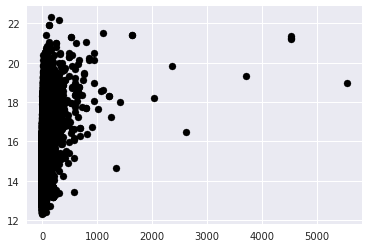

In [25]:
plt.scatter(y =train_Y,x = Train_data.land_area,c = 'black')
plt.show()

In [26]:
train_nas = Train_data.isnull().sum()
train_nas = train_nas[train_nas>0]
train_nas.sort_values(ascending=False)

parking_area             56897
parking_price            46065
txn_floor                15902
village_income_median     1142
dtype: int64

In [27]:
test_nas = Test_data.isnull().sum()
test_nas = test_nas[test_nas>0]
test_nas.sort_values(ascending = False)

parking_area             9500
parking_price            7710
txn_floor                2639
village_income_median     184
dtype: int64

In [28]:
print("Find most important features relative to target")
corr = Train_data.corr()
corr.sort_values(["total_price"], ascending = False, inplace = True)
print(corr.total_price)

Find most important features relative to target
total_price              1.000000
building_area            0.459167
parking_price            0.458674
parking_area             0.377045
land_area                0.313409
master_rate              0.168603
bachelor_rate            0.168585
doc_rate                 0.165599
XIII_5000                0.161861
jobschool_rate           0.150532
village_income_median    0.145541
VII_5000                 0.140251
V_5000                   0.136286
VII_1000                 0.135433
V_1000                   0.135189
XIII_10000               0.134800
IX_5000                  0.133290
VII_10000                0.133018
XI_10000                 0.131184
V_500                    0.130854
VI_10000                 0.130448
IX_1000                  0.129597
IX_10000                 0.129468
V_10000                  0.128324
VII_500                  0.127891
VIII_5000                0.126393
VIII_10000               0.124815
III_10000                0.124746


In [29]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = Train_data.select_dtypes(include=['object']).columns
categorical_features

Index([], dtype='object')

In [31]:
numerical_features = Train_data.select_dtypes(exclude = ["object"]).columns

In [33]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = Train_data.select_dtypes(include = ["object"]).columns
numerical_features = Train_data.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("total_price")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = Train_data[numerical_features]
train_cat = Train_data[categorical_features]

Numerical features : 233
Categorical features : 0


In [34]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 120006
Remaining NAs for numerical features in train : 0


In [35]:
from scipy.stats import skew 
skewness = train_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

parking_area        168.629424
building_area        83.708539
land_area            43.666160
VI_10                29.653905
XIII_10              27.697514
XIII_50              18.246989
IV_10                17.977466
X_10                 17.327541
XIII_100             16.267754
I_10                 15.562572
XI_10                14.459740
XIII_250             11.758670
VIII_50              10.751968
IV_50                10.386136
XIV_50                9.994860
XIV_100               9.850009
VIII_10               9.725941
V_10                  8.827525
parking_price         8.758741
IV_100                8.616982
XIV_10                8.466788
VIII_MIN              8.002173
VI_50                 7.981492
IX_10                 7.972375
IV_250                7.775253
VI_index_50           7.710463
XIII_MIN              7.606773
XIV_250               7.352333
XII_MIN               7.229942
XI_MIN                7.088065
                       ...    
I_index_500          -2.737903
IX_index

In [36]:
skewness = skewness[abs(skewness)>0.5]
skewness.index

Index(['building_material', 'city', 'total_floor', 'building_use',
       'parking_way', 'parking_area', 'parking_price', 'txn_floor',
       'land_area', 'building_area',
       ...
       'XIV_50', 'XIV_index_50', 'XIV_100', 'XIV_250', 'XIV_500',
       'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000', 'XIV_MIN'],
      dtype='object', length=180)

In [38]:
skew_features = Train_data[skewness.index]
skew_features.columns

Index(['building_material', 'city', 'total_floor', 'building_use',
       'parking_way', 'parking_area', 'parking_price', 'txn_floor',
       'land_area', 'building_area',
       ...
       'XIV_50', 'XIV_index_50', 'XIV_100', 'XIV_250', 'XIV_500',
       'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000', 'XIV_MIN'],
      dtype='object', length=180)

In [39]:
#we can treat skewness of a feature with the help fof log transformation.so we'll apply the same here.
skew_features = np.log1p(skew_features)

/home/rex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [40]:
# Create dummy features for categorical values via one-hot encoding
train_cat.shape 

(60000, 0)

In [43]:
#train_cat = pd.get_dummies(train_cat)
#train_cat.shape
#train_cat.head()

In [44]:
Train_data = pd.concat([train_cat,train_num],axis=1)
Train_data.shape

(60000, 233)

In [49]:
#split the data to train the model 
X_train,X_test,y_train,y_test = train_test_split(Train_data,train_Y,test_size = 0.3,random_state= 0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((42000, 233), (18000, 233), (42000,), (18000,))

In [52]:
# Defining cross_val_score function for both train and test sets separately
n_folds = 5
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
scorer = make_scorer(mean_squared_error,greater_is_better = False)
def rmse_CV_train(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(Train_data.values)
    rmse = np.sqrt(-cross_val_score(model,X_train,y_train,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)
def rmse_CV_test(model):
    kf = KFold(n_folds,shuffle=True,random_state=42).get_n_splits(Train_data.values)
    rmse = np.sqrt(-cross_val_score(model,X_test,y_test,scoring ="neg_mean_squared_error",cv=kf))
    return (rmse)

In [54]:
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
train_pre = lr.predict(X_train)
test_pre = lr.predict(X_test)
print('rmse on train',rmse_CV_train(lr).mean())
print('rmse on test',rmse_CV_test(lr).mean())

rmse on train 0.7368384195979345
rmse on test 0.9088651467525002


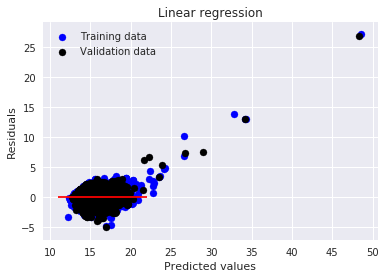

In [58]:
#plot between predicted values and residuals
plt.scatter(train_pre, train_pre - y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre,test_pre - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11, xmax = 22, color = "red")
plt.show()

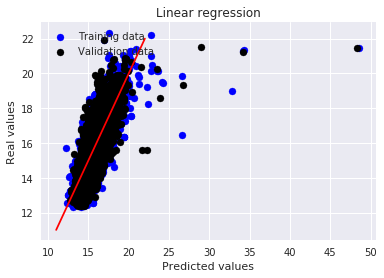

In [60]:
# Plot predictions - Real values
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11, 22], [11, 22], c = "red")
plt.show()

In [63]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train,y_train)
alpha = ridge.alpha_
print('best alpha',alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],cv = 5)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)
print("Ridge RMSE on Training set :", rmse_CV_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_CV_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

best alpha 0.01
Try again for more precision with alphas centered around 0.01
Best alpha : 0.006
Ridge RMSE on Training set : 0.7369423491807341
Ridge RMSE on Test set : 0.909032609609973


In [64]:
coef = pd.Series(ridge.coef_, index = X_train.columns)

print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 211 variables and eliminated the other 22 variables


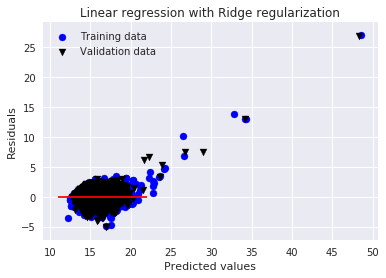

In [65]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue",  label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 11, xmax = 22, color = "red")
plt.show()

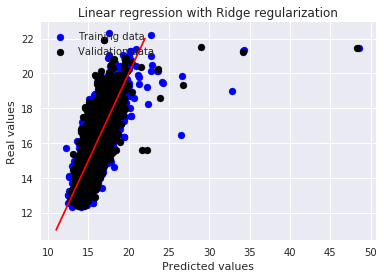

In [66]:
# Plot predictions - Real values
plt.scatter(y_train_rdg, y_train, c = "blue",  label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([11, 22], [11, 22], c = "red")
plt.show()